In [9]:
#using Images, ImageIO, ImageMagick, ImageView, Colors # TestImages,
#using StatsBase, Statistics, LinearAlgebra,  Random
using Plots
using Flux

In [3]:
VERSION

v"1.9.3"

In [7]:
import Pkg
Pkg.status("Flux")

No Matches in `~/.julia/environments/v1.9/Project.toml`


In [63]:
NN = 10

10

In [64]:
#make a 'noisy' square
function noisySquare()
    newPic = ones(NN,NN)
    for rr = 1:NN
        for cc = 1:NN
            if( (rr >= 3 && rr <= 7) && (cc >= 3 && cc <= 7) )
                if( rand() >= 0.1 ) newPic[rr,cc] = 0 end
            end
        end
    end
    return newPic
end

noisySquare (generic function with 1 method)

In [65]:
#function 'noisy cross'
function noisyCross()
    newPic = ones(NN,NN)
    for rr = 1:NN
        for cc = 1:NN
            if( rr == 5 || cc == 5 )
                if( rand() >= 0.1 ) newPic[rr,cc] = 0 end
            end
        end
    end
    return newPic
end

noisyCross (generic function with 1 method)

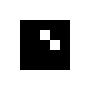

In [66]:
Gray.(noisySquare())

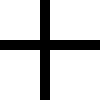

In [67]:
Gray.(noisyCross())

In [68]:
img_Num = 100

100

In [69]:
squares = [vec(noisySquare()) for i in 1:img_Num];
crosses = [vec(noisyCross()) for i in 1:img_Num];

In [70]:
Gray.(squares[1])

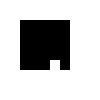

In [71]:
reshape( Gray.(squares[1]) , NN , NN )

In [72]:
size( squares )

(100,)

In [73]:
real_data = vcat( squares , crosses )
size( real_data )

(200,)

In [74]:
#data must be in WxHxCxN but for generator it is 1 d entry so that is WxHxCxN
tmp = Flux.stack( real_data , dims=2 )
display( size( tmp ) )
tmp = reshape( tmp , (10,10,200) )
display( size( tmp ) )
real_data_WHCN = Flux.unsqueeze( tmp , dims = 3 )
size( real_data_WHCN )

(100, 200)

(10, 10, 200)

(10, 10, 1, 200)

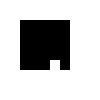

In [75]:
Gray.( real_data_WHCN[ : , : , 1 , 1 ] )

## making the noise vectors to feed into the Generator
### an input which is also a ..latent.. space

In [76]:
latent_dim = 10
function MakeZvectors( batch_num )
    return rand( latent_dim , batch_num )
end

MakeZvectors (generic function with 1 method)

## make the generator, produces an image from the latent space, and relies on the transposed convolution to ..upsampling..

In [77]:

m_gen = Chain( 
      Dense( latent_dim => 100 ) , 
      BatchNorm( 100 , relu ) ,
      x->reshape( x , 5 , 5 , 4 , : ) , #make into WHCN
      ConvTranspose( (4,4) , 4 => 2 ; stride = 1, pad = 1 ) ,
      BatchNorm( 2 , relu ) ,
      ConvTranspose( (5,5) , 2 => 1 ; stride = 1, pad = 1 ) , 
      ConvTranspose( (5,5) , 1 => 1 ; stride = 1, pad = 1 ) , 
      sigmoid
    )

Chain(
  Dense(10 => 100),                     # 1_100 parameters
  BatchNorm(100, relu),                 # 200 parameters, plus 200
  var"#19#20"(),
  ConvTranspose((4, 4), 4 => 2, pad=1),  # 130 parameters
  BatchNorm(2, relu),                   # 4 parameters, plus 4
  ConvTranspose((5, 5), 2 => 1, pad=1),  # 51 parameters
  ConvTranspose((5, 5), 1 => 1, pad=1),  # 26 parameters
  NNlib.σ,
)         # Total: 12 trainable arrays, 1_511 parameters,
          # plus 4 non-trainable, 204 parameters, summarysize 8.332 KiB.

In [78]:
genImg1 = m_gen( MakeZvectors( 4 ) )
genImg1[:,:,:,1]

10×10×1 Array{Float32, 3}:
[:, :, 1] =
 0.504203  0.504383  0.498478  0.509403  …  0.484922  0.499921  0.493821
 0.501256  0.506884  0.500921  0.507197     0.502391  0.511594  0.501432
 0.491089  0.504799  0.489755  0.531424     0.491767  0.504842  0.497027
 0.506196  0.519565  0.486859  0.472105     0.45456   0.480733  0.483366
 0.479924  0.517068  0.488762  0.522988     0.508901  0.498934  0.510963
 0.498289  0.507592  0.456769  0.47406   …  0.454692  0.470179  0.483433
 0.476232  0.51141   0.495285  0.504019     0.470075  0.469103  0.484657
 0.484997  0.501457  0.471314  0.503366     0.491671  0.491043  0.494707
 0.48858   0.511135  0.494988  0.496478     0.48788   0.477104  0.481649
 0.495107  0.500109  0.486558  0.498074     0.4964    0.483811  0.490325

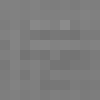

In [79]:
Gray.(genImg1[:,:,1,1])

## build the discriminator, downsample, binary output

In [80]:
m_dis = Chain(
      Conv( (4,4) , 1 => 1 , stride = 1 , pad = 1 ) ,
      relu ,
      Conv( (4,4) , 1 => 1 , stride = 1 , pad = 1 ) ,
      relu ,
      Flux.flatten ,
      Dense( 64 => 10 , relu ) ,
      Dense( 10 => 1 ) ,
      sigmoid
    )

Chain(
  Conv((4, 4), 1 => 1, pad=1),          # 17 parameters
  NNlib.relu,
  Conv((4, 4), 1 => 1, pad=1),          # 17 parameters
  NNlib.relu,
  Flux.flatten,
  Dense(64 => 10, relu),                # 650 parameters
  Dense(10 => 1),                       # 11 parameters
  NNlib.σ,
)                   # Total: 8 arrays, 695 parameters, 3.668 KiB.

In [81]:
m_dis( genImg1[ : , : , : , 1:2 ] )

1×2 Matrix{Float32}:
 0.5  0.5

In [82]:
m_dis( real_data_WHCN[ : , : , : , 1:2 ] )

1×2 Matrix{Float32}:
 0.523774  0.529432

In [83]:
genImg2 = m_gen( MakeZvectors( 4 ) )
m_dis( genImg2 )

1×4 Matrix{Float32}:
 0.5  0.5  0.5  0.5

## feeds in the discriminator's output from a fake synthetic example

In [84]:
function generator_loss( fake_output ) 
    Flux.binarycrossentropy( fake_output , 1 )
end

generator_loss (generic function with 1 method)

In [85]:
## add the loss from the real and fake inputs

In [86]:
function discriminator_loss( real_output , fake_output )
    real_loss = Flux.binarycrossentropy( real_output , 1 )
    fake_loss = Flux.binarycrossentropy( fake_output , 0 )
    return real_loss + fake_loss
end

discriminator_loss (generic function with 1 method)

In [87]:
## optmize the generator based upon the gradient of the loss of how well the discriminator does

In [101]:
function train_generator( gen , dscr , opt_gen , batch_num )
    noise = MakeZvectors( batch_num )
    # Taking gradient
    loss, grads = Flux.withgradient( gen ) do gen
        generator_loss( dscr( gen( noise ) ) )
    end
    Flux.update!( opt_gen , gen , grads[1] )
    return loss
end

train_generator (generic function with 1 method)

In [102]:
## feed the inputs of real and fake independently

In [103]:
function train_discriminator( gen , dscr , x , opt_dscr , batch_num )
    noise = MakeZvectors( batch_num )
    fake_input = gen( noise )
    # Taking gradient
    loss, grads = Flux.withgradient(dscr) do dscr
        discriminator_loss( dscr( x ) , dscr( fake_input ) )
    end
    Flux.update!( opt_dscr , dscr , grads[1] )
    return loss
end

train_discriminator (generic function with 1 method)

In [104]:
opt_dis = Flux.setup( Adam( 0.0001 ) , m_dis )
opt_gen = Flux.setup( Adam( 0.0001 ) , m_gen );

In [105]:
train_discriminator( m_gen , m_dis , real_data_WHCN[:,:,:,1:2] , opt_dis , 2 )

1.6258866f0

In [106]:
train_generator( m_gen , m_dis , opt_gen , 2 )

LoadError: UndefVarError: params not defined

In [107]:
loss_dis_array = []
loss_gen_array = []

Any[]

In [108]:
batch_num = 5

for epoch in 1:10000
    
    tmp_inds = Random.randperm(size(real_data_WHCN)[4])[1:batch_num]
    x_real_tmp = real_data_WHCN[:,:,:,tmp_inds]
        
    loss_dis = train_discriminator( m_gen , m_dis , x_real_tmp , opt_dis , batch_num ) 
    push!( loss_dis_array , loss_dis )
    loss_gen = train_generator( m_gen , m_dis , opt_gen , batch_num )
    push!( loss_gen_array , loss_gen )
    
end

LoadError: UndefVarError: params not defined

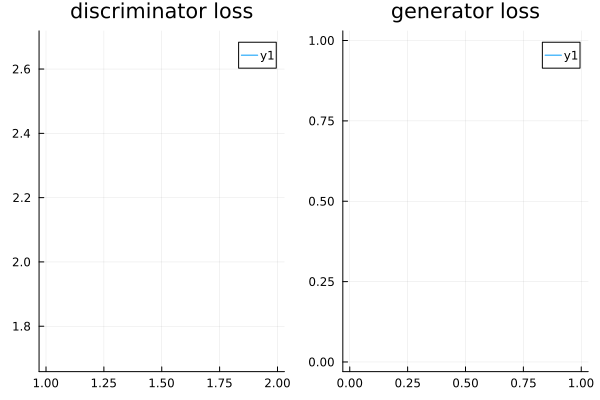

In [109]:
p_dis = plot( loss_dis_array , title="discriminator loss" )
p_gen = plot( loss_gen_array , title="generator loss" )
plot( p_dis , p_gen )

In [110]:
m_dis( real_data_WHCN[ : , : , : , 1:2 ] )

1×2 Matrix{Float32}:
 0.32686  0.288653

In [98]:
m_dis( m_gen( MakeZvectors( 2 ) ) )

1×2 Matrix{Float32}:
 0.320854  0.44356

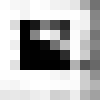

In [99]:
Gray.( m_gen( MakeZvectors( 1 ) )[:,:,1,1] )

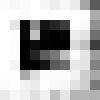

In [100]:
Gray.( m_gen( MakeZvectors( 1 ) )[:,:,1,1] )